# Degridder Experiment - Analysis and Visualization

This notebook handles the analysis and visualization of the degridder experiment results.
It loads data generated by the `compilation_execution.ipynb` notebook and creates comprehensive graphs comparing Preesm and IARA performance.

## Analysis includes:
1. Binary size comparison
2. Scheduling time comparison  
3. Execution wall time comparison
4. Memory usage (max RSS) comparison
5. Combined performance visualizations

Make sure to run `compilation_execution.ipynb` first to generate the required data.

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional, Union
import matplotlib.axes

# Load experiment directory and regenerate scenario data
experiment_dir = !realpath ~/repos/iara/experiment/degridder
experiment_dir = experiment_dir[0]

print(f"Loading experiment data from: {experiment_dir}/instances/")

# Recreate the scenario generation logic from the compilation notebook
grid_size = 5120
num_visibilities = 7848960

class Scenario:
  def __init__(self, name: str, num_cores: int, num_chunks: int, num_supports: int, grid_size: int, num_visibilities: int):
    self.name = name
    self.instance_path = f"{experiment_dir}/instances/{name}"
    self.iara_bin_path = None
    self.preesm_bin_path = None
    self.iara_scheduling_time = None
    self.preesm_scheduling_time = None
    self.srdag_edges = None
    self.srdag_nodes = None
    self.preesm_bin_size = None
    self.iara_bin_size = None
    self.num_cores = num_cores
    self.num_supports = num_supports
    self.num_chunks = num_chunks
    self.num_visibilities = num_visibilities
    self.grid_size = grid_size
    self.dataset_size = "large"
    # Execution performance data
    self.preesm_wall_time = None
    self.preesm_max_rss = None
    self.iara_wall_time = None
    self.iara_max_rss = None

# Recreate the scenario list by scanning the instances directory
import glob
instance_dirs = glob.glob(f"{experiment_dir}/instances/generated_large_*")
all_ordered_scenarios = []

print(instance_dirs)

for instance_dir in instance_dirs:
    scenario_name = os.path.basename(instance_dir)
    # Parse the scenario name to extract parameters
    # Format: generated_large_{num_cores}cores_{num_chunks}chunks_{num_supports}supports.scenario
    parts = scenario_name.replace('.scenario', '').split('_')

    try:
        num_cores = int(parts[2].replace('cores', ''))
        num_chunks = int(parts[3].replace('chunks', ''))
        num_supports = int(parts[4].replace('supports', ''))
        scenario = Scenario(scenario_name, num_cores, num_chunks, num_supports, grid_size, num_visibilities)
        all_ordered_scenarios.append(scenario)
    except ValueError:
        print(f"Warning: Could not parse scenario name: {scenario_name}")

print(f"Found {len(all_ordered_scenarios)} scenarios from instance directories")

Loading experiment data from: /home/jabcross/repos/iara/experiment/degridder/instances/
['/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_1chunks_8supports.scenario', '/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_512chunks_8supports.scenario', '/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_32chunks_8supports.scenario', '/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_2chunks_8supports.scenario', '/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_16chunks_8supports.scenario', '/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_8chunks_8supports.scenario', '/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_4chunks_8supports.scenario', '/home/jabcross/repos/iara/experiment/degridder/instances/generated_large_1cores_64chunks_8supports.scenario', '/home/jabcross/repos/iara

In [16]:
# Read all experiment data from files
import re

def parse_time_file(file_path):
    """Parse /usr/bin/time -v output to extract wall time and max RSS"""
    try:
        with open(file_path, 'r') as f:
            content = f.read()
        
        # Extract wall clock time (format: h:mm:ss or mm:ss.ss)
        wall_time_match = re.search(r'Elapsed \(wall clock\) time \(h:mm:ss or m:ss\): (.+)', content)
        wall_time_seconds = None
        if wall_time_match:
            time_str = wall_time_match.group(1).strip()
            if ':' in time_str:
                parts = time_str.split(':')
                if len(parts) == 3:  # h:mm:ss
                    hours, minutes, seconds = parts
                    wall_time_seconds = float(hours) * 3600 + float(minutes) * 60 + float(seconds)
                elif len(parts) == 2:  # mm:ss
                    minutes, seconds = parts
                    wall_time_seconds = float(minutes) * 60 + float(seconds)
            else:
                wall_time_seconds = float(time_str)
        
        # Extract maximum resident set size (in KB)
        max_rss_match = re.search(r'Maximum resident set size \(kbytes\): (\d+)', content)
        max_rss_kb = int(max_rss_match.group(1)) if max_rss_match else None
        
        return wall_time_seconds, max_rss_kb
    except FileNotFoundError:
        return None, None
    except Exception as e:
        print(f"Error parsing {file_path}: {e}")
        return None, None

# Read compilation data from Preesm
print("Reading Preesm compilation data...")
for scenario in all_ordered_scenarios:
    # Read binary size
    scenario.preesm_bin_path = f'{experiment_dir}/instances/{scenario.name}/preesm_build/degridder_pipeline'
    if os.path.exists(scenario.preesm_bin_path):
        scenario.preesm_bin_size = os.path.getsize(scenario.preesm_bin_path)
        
        # Read scheduling time
        scheduling_time_file = f'{experiment_dir}/instances/{scenario.name}/preesm_scheduling_time.txt'
        if os.path.exists(scheduling_time_file):
            try:
                walltime_str = !grep "wall clock" '{scheduling_time_file}' | cut -f 8 -d ' '
                if walltime_str:
                    time_str = walltime_str[0].strip()
                    minutes, seconds = time_str.split(':')
                    scenario.preesm_scheduling_time = float(minutes) * 60 + float(seconds)
            except:
                scenario.preesm_scheduling_time = None

    # Read SRDAG information
    preesm_stdout_file = f'{experiment_dir}/instances/{scenario.name}/preesm_stdout.txt'
    if os.path.exists(preesm_stdout_file):
        try:
            srdag_output = !grep "SRDAG" '{preesm_stdout_file}'
            if srdag_output and len(srdag_output) > 0:
                match = re.search(r'SRDAG with (\d+) vertices and (\d+) edges', srdag_output[0])
                if match:
                    scenario.srdag_nodes = int(match.group(1))
                    scenario.srdag_edges = int(match.group(2))
        except:
            pass

# Read compilation data from IARA
print("Reading IARA compilation data...")
for scenario in all_ordered_scenarios:
    # Read binary size
    scenario.iara_bin_path = f'{experiment_dir}/instances/{scenario.name}/build/degridder_pipeline'
    if os.path.exists(scenario.iara_bin_path):
        scenario.iara_bin_size = os.path.getsize(scenario.iara_bin_path)
        
        # Read scheduling time
        scheduling_time_file = f'{experiment_dir}/instances/{scenario.name}/iara_scheduling_time.txt'
        if os.path.exists(scheduling_time_file):
            try:
                walltime_str = !grep "wall clock" '{scheduling_time_file}' | cut -f 8 -d ' '
                if walltime_str:
                    time_str = walltime_str[0].strip()
                    minutes, seconds = time_str.split(':')
                    scenario.iara_scheduling_time = float(minutes) * 60 + float(seconds)
            except:
                scenario.iara_scheduling_time = None

# Read execution performance data
print("Reading execution performance data...")
for scenario in all_ordered_scenarios:
    # Parse Preesm execution data
    preesm_time_file = f'{experiment_dir}/instances/{scenario.name}/preesm_degridder_time.txt'
    scenario.preesm_wall_time, scenario.preesm_max_rss = parse_time_file(preesm_time_file)
    
    # Parse IARA execution data
    iara_time_file = f'{experiment_dir}/instances/{scenario.name}/iara_degridder_time.txt'
    scenario.iara_wall_time, scenario.iara_max_rss = parse_time_file(iara_time_file)

print(f"Data loading complete!")
print(f"Scenarios with Preesm compilation: {sum(1 for s in all_ordered_scenarios if s.preesm_bin_size)}")
print(f"Scenarios with IARA compilation: {sum(1 for s in all_ordered_scenarios if s.iara_bin_size)}")
print(f"Scenarios with SRDAG data: {sum(1 for s in all_ordered_scenarios if s.srdag_edges)}")
print(f"Scenarios with Preesm execution data: {sum(1 for s in all_ordered_scenarios if s.preesm_wall_time)}")
print(f"Scenarios with IARA execution data: {sum(1 for s in all_ordered_scenarios if s.iara_wall_time)}")

Reading Preesm compilation data...
Reading IARA compilation data...
Reading execution performance data...
Data loading complete!
Scenarios with Preesm compilation: 18
Scenarios with IARA compilation: 40
Scenarios with SRDAG data: 20
Scenarios with Preesm execution data: 18
Scenarios with IARA execution data: 40


In [26]:
# Filter and prepare scenarios for analysis

# Don't filter out scenarios - show all scenarios including those without SRDAG data
scenario_list = all_ordered_scenarios
scenario_list.sort(key=lambda s: (s.srdag_edges if s.srdag_edges else 9999999999, s.num_cores, s.num_chunks, s.num_supports))

print(f"Using all {len(scenario_list)} scenarios for analysis (including those without SRDAG data)")
print(f"Scenarios with SRDAG data: {sum(1 for s in scenario_list if s.srdag_edges is not None)}")
print(f"Scenarios without SRDAG data: {sum(1 for s in scenario_list if s.srdag_edges is None)}")

Using all 40 scenarios for analysis (including those without SRDAG data)
Scenarios with SRDAG data: 20
Scenarios without SRDAG data: 20


In [18]:
# Helper functions for plotting to reduce code repetition

def add_timeout_labels(ax: matplotlib.axes.Axes, x_positions: np.ndarray, values: List[Optional[float]], bar_width_offset: float = 0) -> float:
    """Add 'Timeout' labels for None values in the data and return their height in graph units"""
    timeout_height_in_graph_units = 0

    for idx, val in enumerate(values):
        if val is None:
            # Add the timeout label
            text_obj = ax.text(x_positions[idx] + bar_width_offset, 0.5, 'Timeout',
                               ha='center', va='bottom', color='red', rotation=90)

            # Calculate the height of the rotated text in graph units
            # For a 90-degree rotated text, the height becomes the width in graph coordinates
            renderer = ax.figure.canvas.get_renderer()
            bbox = text_obj.get_window_extent(renderer=renderer)

            # Transform from display coordinates to data coordinates
            bbox_data = bbox.transformed(ax.transData.inverted())

            # For rotated text (90 degrees), width in display becomes height in graph
            text_width_in_data = bbox_data.height
            # This is the "height" of rotated text
            text_height_in_graph = text_width_in_data

            timeout_height_in_graph_units = max(
                timeout_height_in_graph_units, text_height_in_graph + 0.5)

    return timeout_height_in_graph_units


def add_edge_count_labels(ax: matplotlib.axes.Axes, x_positions: np.ndarray, values: List[Optional[float]],
                          srdag_edges: List[Optional[int]], offset_percentage: float = 0.05,
                          timeout_height: float = 0) -> None:
    """Add edge count labels above bars, with offset relative to graph scale"""
    # Calculate offset based on the current y-axis range
    y_min, y_max = ax.get_ylim()
    graph_scale_offset = (y_max - y_min) * offset_percentage

    for idx, edge_count in enumerate(srdag_edges):
        if edge_count is not None:
            max_height = values[idx] if values[idx] is not None else 0
            max_height = max(max_height, (timeout_height *1.1) if values[idx] is None else 0)

            y_position = max_height + graph_scale_offset

            ax.text(x_positions[idx], y_position,
                    f"#edges:\n{edge_count}",
                    ha='center', va='bottom', fontsize=8, color='black')


def setup_bar_plot(ax: matplotlib.axes.Axes, x_positions: np.ndarray, values: List[Optional[float]],
                   bar_width: float, color_map: List[str],
                   ylabel: str, xlabel: str, title: str, scenario_names: List[str]) -> matplotlib.container.BarContainer:
    """Setup a basic bar plot with common formatting"""
    bars = ax.bar(x_positions, [v if v is not None else 0 for v in values],
                  bar_width, color=color_map)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(scenario_names, rotation=90)
    return bars


def set_ylim_with_padding(ax: matplotlib.axes.Axes, values: List[Optional[float]],
                          padding_factor: float = 1.2, min_timeout_space: float = 20.0) -> None:
    """Set y-axis limits with padding to accommodate labels and timeout scenarios"""
    max_val = max([v for v in values if v is not None], default=0)
    if max_val > 0:
        ax.set_ylim(0, max_val * padding_factor)
    else:
        # If all values are None (timeouts), ensure enough space for labels
        ax.set_ylim(0, min_timeout_space)

print("Helper functions loaded successfully")

Helper functions loaded successfully


In [27]:
# Prepare data for plotting
scenario_names = [s.name for s in scenario_list]
preesm_sizes = [s.preesm_bin_size for s in scenario_list]
iara_sizes = [s.iara_bin_size for s in scenario_list]
srdag_edges = [s.srdag_edges for s in scenario_list]
preesm_times = [s.preesm_scheduling_time for s in scenario_list]
iara_times = [s.iara_scheduling_time for s in scenario_list]
preesm_wall_times = [s.preesm_wall_time for s in scenario_list]
iara_wall_times = [s.iara_wall_time for s in scenario_list]
preesm_max_rss = [s.preesm_max_rss for s in scenario_list]
iara_max_rss = [s.iara_max_rss for s in scenario_list]

x = np.arange(len(scenario_names))
width = 0.35

print(f"Prepared data for {len(scenario_names)} scenarios")
print(f"Binary size data available for {sum(1 for s in preesm_sizes if s is not None)} Preesm and {sum(1 for s in iara_sizes if s is not None)} IARA scenarios")
print(f"Execution data available for {sum(1 for s in preesm_wall_times if s is not None)} Preesm and {sum(1 for s in iara_wall_times if s is not None)} IARA scenarios")

Prepared data for 40 scenarios
Binary size data available for 18 Preesm and 40 IARA scenarios
Execution data available for 40 Preesm and 40 IARA scenarios


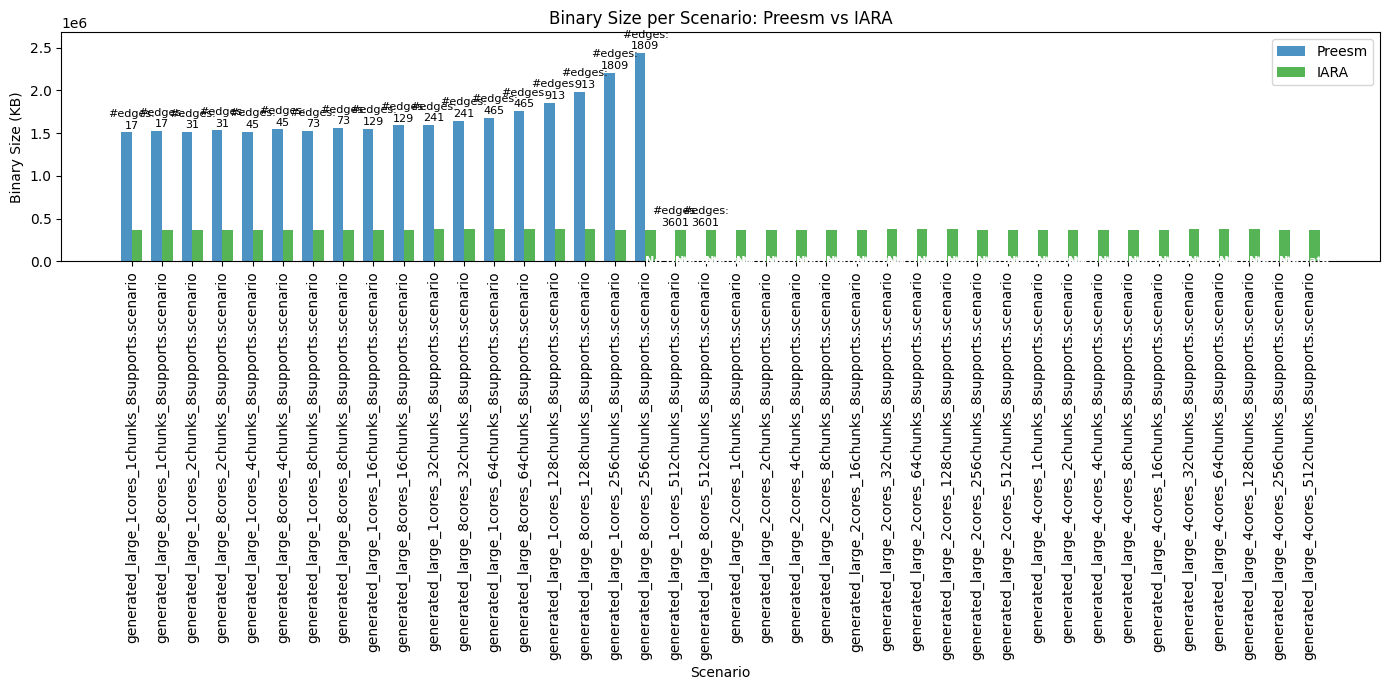

In [29]:
# Binary Size Comparison
fig, ax = plt.subplots(figsize=(14, 7))

# Create color maps for the bars - use red for missing data
preesm_colors = ['tab:blue' if s is not None else 'tab:red' for s in preesm_sizes]
iara_colors = ['tab:green' if s is not None else 'tab:red' for s in iara_sizes]

# Plot bars - show 0 height bars for missing data so they're visible
bars1 = ax.bar(x - width/2, [s if s is not None else 0 for s in preesm_sizes], 
              width, label='Preesm', color=preesm_colors, alpha=0.8)
bars2 = ax.bar(x + width/2, [s if s is not None else 0 for s in iara_sizes], 
              width, label='IARA', color=iara_colors, alpha=0.8)

# Add small height for missing data bars to make them visible
missing_height = 5000  # Small visible height for missing data
for idx, (preesm_size, iara_size) in enumerate(zip(preesm_sizes, iara_sizes)):
    if preesm_size is None:
        bars1[idx].set_height(missing_height)
        bars1[idx].set_alpha(0.5)
    if iara_size is None:
        bars2[idx].set_height(missing_height)
        bars2[idx].set_alpha(0.5)

ax.set_ylabel('Binary Size (KB)')
ax.set_xlabel('Scenario')
ax.set_title('Binary Size per Scenario: Preesm vs IARA')
ax.set_xticks(x)
ax.set_xticklabels(scenario_names, rotation=90)
ax.legend()

# Add "Timeout" labels for missing scenarios
for idx, (preesm_size, iara_size) in enumerate(zip(preesm_sizes, iara_sizes)):
    if preesm_size is None:
        ax.text(x[idx] - width/2, missing_height/2, 'Timeout', 
               ha='center', va='center', color='red', fontsize=8, fontweight='bold')
    if iara_size is None:
        ax.text(x[idx] + width/2, missing_height/2, 'Timeout', 
               ha='center', va='center', color='red', fontsize=8, fontweight='bold')

# Add edge count labels
for idx, edge_count in enumerate(srdag_edges):
  if edge_count is not None:
    max_height = max(
      (preesm_sizes[idx] if preesm_sizes[idx] is not None else missing_height),
      (iara_sizes[idx] if iara_sizes[idx] is not None else missing_height)
    )
    if max_height > missing_height:  # Only add edge labels if we have real data
        ax.text(x[idx], max_height + 20000, f"#edges:\n{edge_count}", 
               ha='center', va='bottom', fontsize=8, color='black')

# Set y-axis limits
real_data = [s for s in preesm_sizes + iara_sizes if s is not None]
if real_data:
    ymax = max(real_data)
    ax.set_ylim(0, ymax * 1.1)
else:
    ax.set_ylim(0, missing_height * 2)

plt.tight_layout()
plt.show()

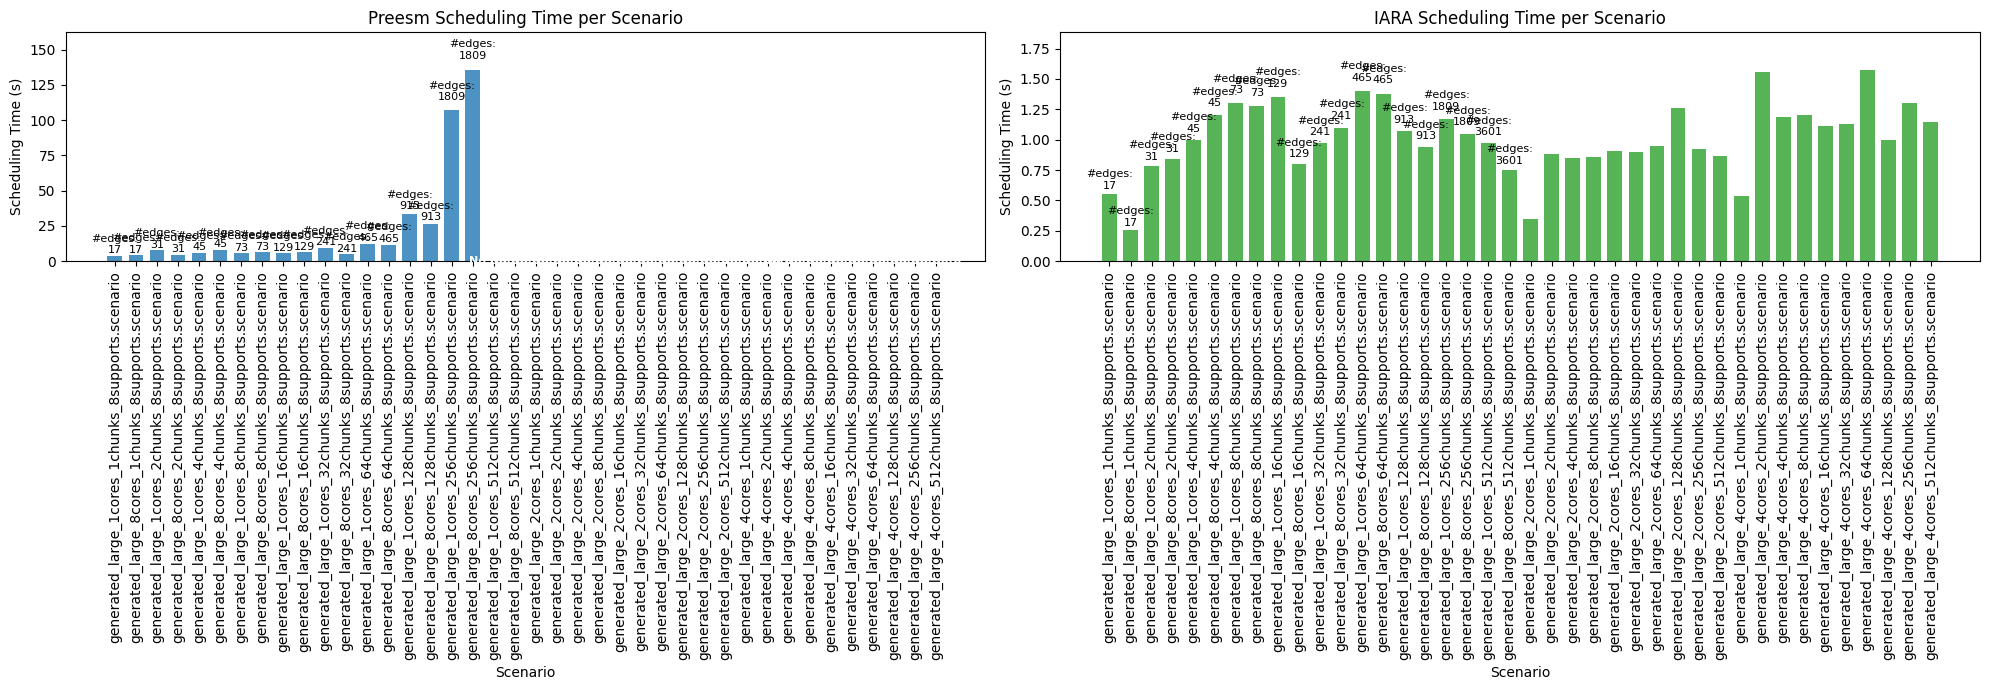

In [30]:
# Scheduling Time Comparison
# Create two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Create color maps - use red for missing data
preesm_colors = ['tab:blue' if t is not None else 'tab:red' for t in preesm_times]
iara_colors = ['tab:green' if t is not None else 'tab:red' for t in iara_times]

# Plot Preesm times
bars1 = ax1.bar(x, [t if t is not None else 0 for t in preesm_times], 
               width*2, color=preesm_colors, alpha=0.8)
ax1.set_ylabel('Scheduling Time (s)')
ax1.set_xlabel('Scenario')
ax1.set_title('Preesm Scheduling Time per Scenario')
ax1.set_xticks(x)
ax1.set_xticklabels(scenario_names, rotation=90)

# Add small height for missing data bars to make them visible
missing_height_time = 0.1  # Small visible height for missing scheduling time data
for idx, preesm_time in enumerate(preesm_times):
    if preesm_time is None:
        bars1[idx].set_height(missing_height_time)
        bars1[idx].set_alpha(0.5)

# Add "Timeout" labels for missing scenarios
for idx, preesm_time in enumerate(preesm_times):
    if preesm_time is None:
        ax1.text(x[idx], missing_height_time/2, 'Timeout', 
               ha='center', va='center', color='red', fontsize=8, fontweight='bold')

# Add edge count labels for Preesm
for idx, edge_count in enumerate(srdag_edges):
    if edge_count is not None:
        max_height = preesm_times[idx] if preesm_times[idx] is not None else missing_height_time
        if max_height > missing_height_time:  # Only add edge labels if we have real data
            ax1.text(x[idx], max_height * 1.05, f"#edges:\n{edge_count}", 
                   ha='center', va='bottom', fontsize=8, color='black')

# Set y-axis limits for Preesm
real_preesm_times = [t for t in preesm_times if t is not None]
if real_preesm_times:
    ymax_preesm = max(real_preesm_times)
    ax1.set_ylim(0, ymax_preesm * 1.2)
else:
    ax1.set_ylim(0, missing_height_time * 2)

# Plot IARA times
bars2 = ax2.bar(x, [t if t is not None else 0 for t in iara_times], 
               width*2, color=iara_colors, alpha=0.8)
ax2.set_ylabel('Scheduling Time (s)')
ax2.set_xlabel('Scenario')
ax2.set_title('IARA Scheduling Time per Scenario')
ax2.set_xticks(x)
ax2.set_xticklabels(scenario_names, rotation=90)

# Add small height for missing data bars to make them visible
for idx, iara_time in enumerate(iara_times):
    if iara_time is None:
        bars2[idx].set_height(missing_height_time)
        bars2[idx].set_alpha(0.5)

# Add "Timeout" labels for missing scenarios
for idx, iara_time in enumerate(iara_times):
    if iara_time is None:
        ax2.text(x[idx], missing_height_time/2, 'Timeout', 
               ha='center', va='center', color='red', fontsize=8, fontweight='bold')

# Add edge count labels for IARA
for idx, edge_count in enumerate(srdag_edges):
    if edge_count is not None:
        max_height = iara_times[idx] if iara_times[idx] is not None else missing_height_time
        if max_height > missing_height_time:  # Only add edge labels if we have real data
            ax2.text(x[idx], max_height * 1.05, f"#edges:\n{edge_count}", 
                   ha='center', va='bottom', fontsize=8, color='black')

# Set y-axis limits for IARA
real_iara_times = [t for t in iara_times if t is not None]
if real_iara_times:
    ymax_iara = max(real_iara_times)
    ax2.set_ylim(0, ymax_iara * 1.2)
else:
    ax2.set_ylim(0, missing_height_time * 2)

plt.tight_layout()
plt.show()

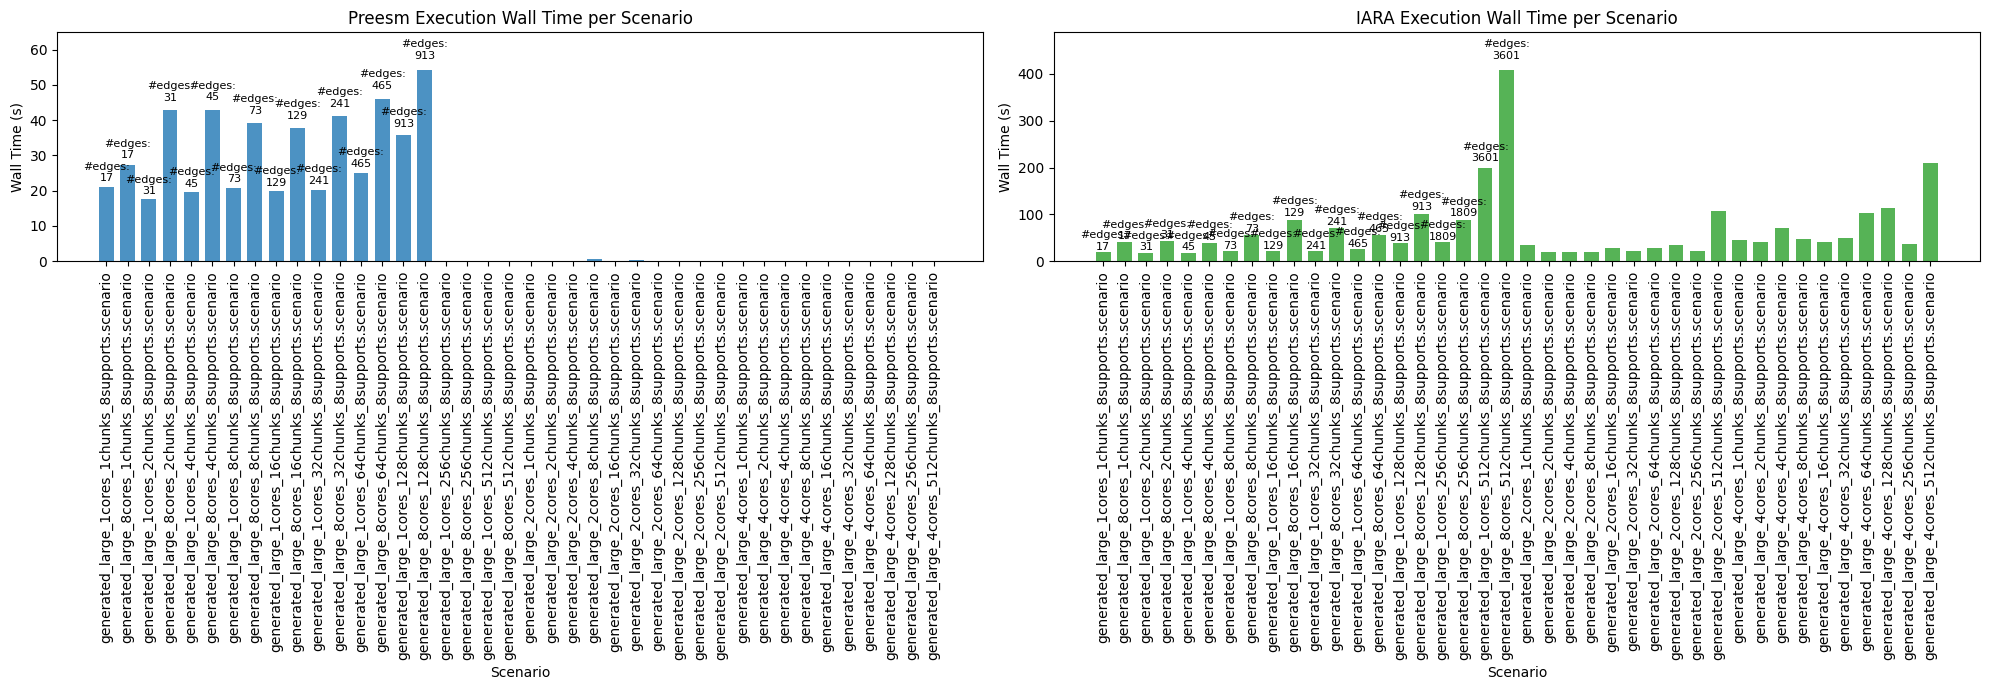

In [33]:
# Execution Wall Time Comparison
# Create two side-by-side subplots for wall time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Create color maps - use red for missing data
preesm_colors = ['tab:blue' if t is not None else 'tab:red' for t in preesm_wall_times]
iara_colors = ['tab:green' if t is not None else 'tab:red' for t in iara_wall_times]

# Plot Preesm wall times
bars1 = ax1.bar(x, [t if t is not None else 0 for t in preesm_wall_times], 
               width*2, color=preesm_colors, alpha=0.8)
ax1.set_ylabel('Wall Time (s)')
ax1.set_xlabel('Scenario')
ax1.set_title('Preesm Execution Wall Time per Scenario')
ax1.set_xticks(x)
ax1.set_xticklabels(scenario_names, rotation=90)

# Add small height for missing data bars to make them visible
missing_height_wall = 0.5  # Small visible height for missing wall time data
for idx, preesm_wall_time in enumerate(preesm_wall_times):
    if preesm_wall_time is None:
        bars1[idx].set_height(missing_height_wall)
        bars1[idx].set_alpha(0.5)

# Add "Timeout" labels for missing scenarios
for idx, preesm_wall_time in enumerate(preesm_wall_times):
    if preesm_wall_time is None:
        ax1.text(x[idx], missing_height_wall/2, 'Timeout', 
               ha='center', va='center', color='red', fontsize=8, fontweight='bold')

# Add edge count labels for Preesm
for idx, edge_count in enumerate(srdag_edges):
    if edge_count is not None:
        max_height = preesm_wall_times[idx] if preesm_wall_times[idx] is not None else missing_height_wall
        if max_height > missing_height_wall:  # Only add edge labels if we have real data
            ax1.text(x[idx], max_height * 1.05, f"#edges:\n{edge_count}", 
                   ha='center', va='bottom', fontsize=8, color='black')

# Set y-axis limits for Preesm
real_preesm_wall_times = [t for t in preesm_wall_times if t is not None]
if real_preesm_wall_times:
    ymax_preesm = max(real_preesm_wall_times)
    ax1.set_ylim(0, ymax_preesm * 1.2)
else:
    ax1.set_ylim(0, missing_height_wall * 2)

# Plot IARA wall times
bars2 = ax2.bar(x, [t if t is not None else 0 for t in iara_wall_times], 
               width*2, color=iara_colors, alpha=0.8)
ax2.set_ylabel('Wall Time (s)')
ax2.set_xlabel('Scenario')
ax2.set_title('IARA Execution Wall Time per Scenario')
ax2.set_xticks(x)
ax2.set_xticklabels(scenario_names, rotation=90)

# Add small height for missing data bars to make them visible
for idx, iara_wall_time in enumerate(iara_wall_times):
    if iara_wall_time is None:
        bars2[idx].set_height(missing_height_wall)
        bars2[idx].set_alpha(0.5)

# Add "Timeout" labels for missing scenarios
for idx, iara_wall_time in enumerate(iara_wall_times):
    if iara_wall_time is None:
        ax2.text(x[idx], missing_height_wall/2, 'Timeout', 
               ha='center', va='center', color='red', fontsize=8, fontweight='bold')

# Add edge count labels for IARA
for idx, edge_count in enumerate(srdag_edges):
    if edge_count is not None:
        max_height = iara_wall_times[idx] if iara_wall_times[idx] is not None else missing_height_wall
        if max_height > missing_height_wall:  # Only add edge labels if we have real data
            ax2.text(x[idx], max_height * 1.05, f"#edges:\n{edge_count}", 
                   ha='center', va='bottom', fontsize=8, color='black')

# Set y-axis limits for IARA
real_iara_wall_times = [t for t in iara_wall_times if t is not None]
if real_iara_wall_times:
    ymax_iara = max(real_iara_wall_times)
    ax2.set_ylim(0, ymax_iara * 1.2)
else:
    ax2.set_ylim(0, missing_height_wall * 2)

plt.tight_layout()
plt.show()

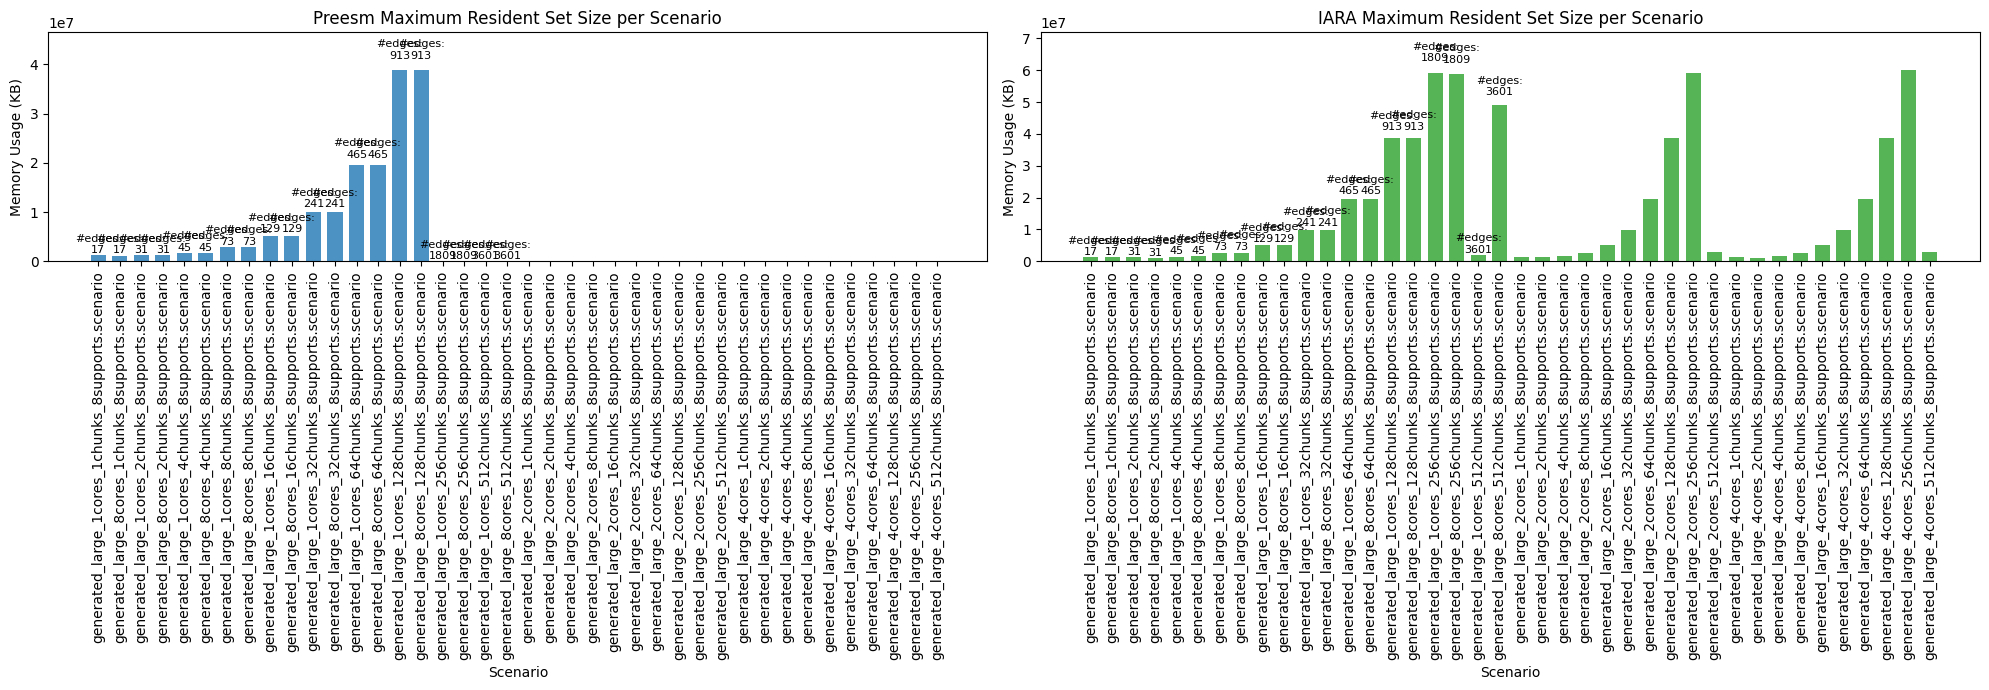

In [32]:
# Memory Usage (Max RSS) Comparison
# Create two side-by-side subplots for memory usage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Create color maps - use red for missing data
preesm_colors = ['tab:blue' if rss is not None else 'tab:red' for rss in preesm_max_rss]
iara_colors = ['tab:green' if rss is not None else 'tab:red' for rss in iara_max_rss]

# Plot Preesm memory usage
bars1 = ax1.bar(x, [rss if rss is not None else 0 for rss in preesm_max_rss], 
               width*2, color=preesm_colors, alpha=0.8)
ax1.set_ylabel('Memory Usage (KB)')
ax1.set_xlabel('Scenario')
ax1.set_title('Preesm Maximum Resident Set Size per Scenario')
ax1.set_xticks(x)
ax1.set_xticklabels(scenario_names, rotation=90)

# Add small height for missing data bars to make them visible
missing_height_rss = 1000  # Small visible height for missing memory data
for idx, preesm_rss in enumerate(preesm_max_rss):
    if preesm_rss is None:
        bars1[idx].set_height(missing_height_rss)
        bars1[idx].set_alpha(0.5)

# Add "Timeout" labels for missing scenarios
for idx, preesm_rss in enumerate(preesm_max_rss):
    if preesm_rss is None:
        ax1.text(x[idx], missing_height_rss/2, 'Timeout', 
               ha='center', va='center', color='red', fontsize=8, fontweight='bold')

# Add edge count labels for Preesm
for idx, edge_count in enumerate(srdag_edges):
    if edge_count is not None:
        max_height = preesm_max_rss[idx] if preesm_max_rss[idx] is not None else missing_height_rss
        if max_height > missing_height_rss:  # Only add edge labels if we have real data
            ax1.text(x[idx], max_height * 1.05, f"#edges:\n{edge_count}", 
                   ha='center', va='bottom', fontsize=8, color='black')

# Set y-axis limits for Preesm
real_preesm_rss = [rss for rss in preesm_max_rss if rss is not None]
if real_preesm_rss:
    ymax_preesm = max(real_preesm_rss)
    ax1.set_ylim(0, ymax_preesm * 1.2)
else:
    ax1.set_ylim(0, missing_height_rss * 2)

# Plot IARA memory usage
bars2 = ax2.bar(x, [rss if rss is not None else 0 for rss in iara_max_rss], 
               width*2, color=iara_colors, alpha=0.8)
ax2.set_ylabel('Memory Usage (KB)')
ax2.set_xlabel('Scenario')
ax2.set_title('IARA Maximum Resident Set Size per Scenario')
ax2.set_xticks(x)
ax2.set_xticklabels(scenario_names, rotation=90)

# Add small height for missing data bars to make them visible
for idx, iara_rss in enumerate(iara_max_rss):
    if iara_rss is None:
        bars2[idx].set_height(missing_height_rss)
        bars2[idx].set_alpha(0.5)

# Add "Timeout" labels for missing scenarios
for idx, iara_rss in enumerate(iara_max_rss):
    if iara_rss is None:
        ax2.text(x[idx], missing_height_rss/2, 'Timeout', 
               ha='center', va='center', color='red', fontsize=8, fontweight='bold')

# Add edge count labels for IARA
for idx, edge_count in enumerate(srdag_edges):
    if edge_count is not None:
        max_height = iara_max_rss[idx] if iara_max_rss[idx] is not None else missing_height_rss
        if max_height > missing_height_rss:  # Only add edge labels if we have real data
            ax2.text(x[idx], max_height * 1.05, f"#edges:\n{edge_count}", 
                   ha='center', va='bottom', fontsize=8, color='black')

# Set y-axis limits for IARA
real_iara_rss = [rss for rss in iara_max_rss if rss is not None]
if real_iara_rss:
    ymax_iara = max(real_iara_rss)
    ax2.set_ylim(0, ymax_iara * 1.2)
else:
    ax2.set_ylim(0, missing_height_rss * 2)

plt.tight_layout()
plt.show()

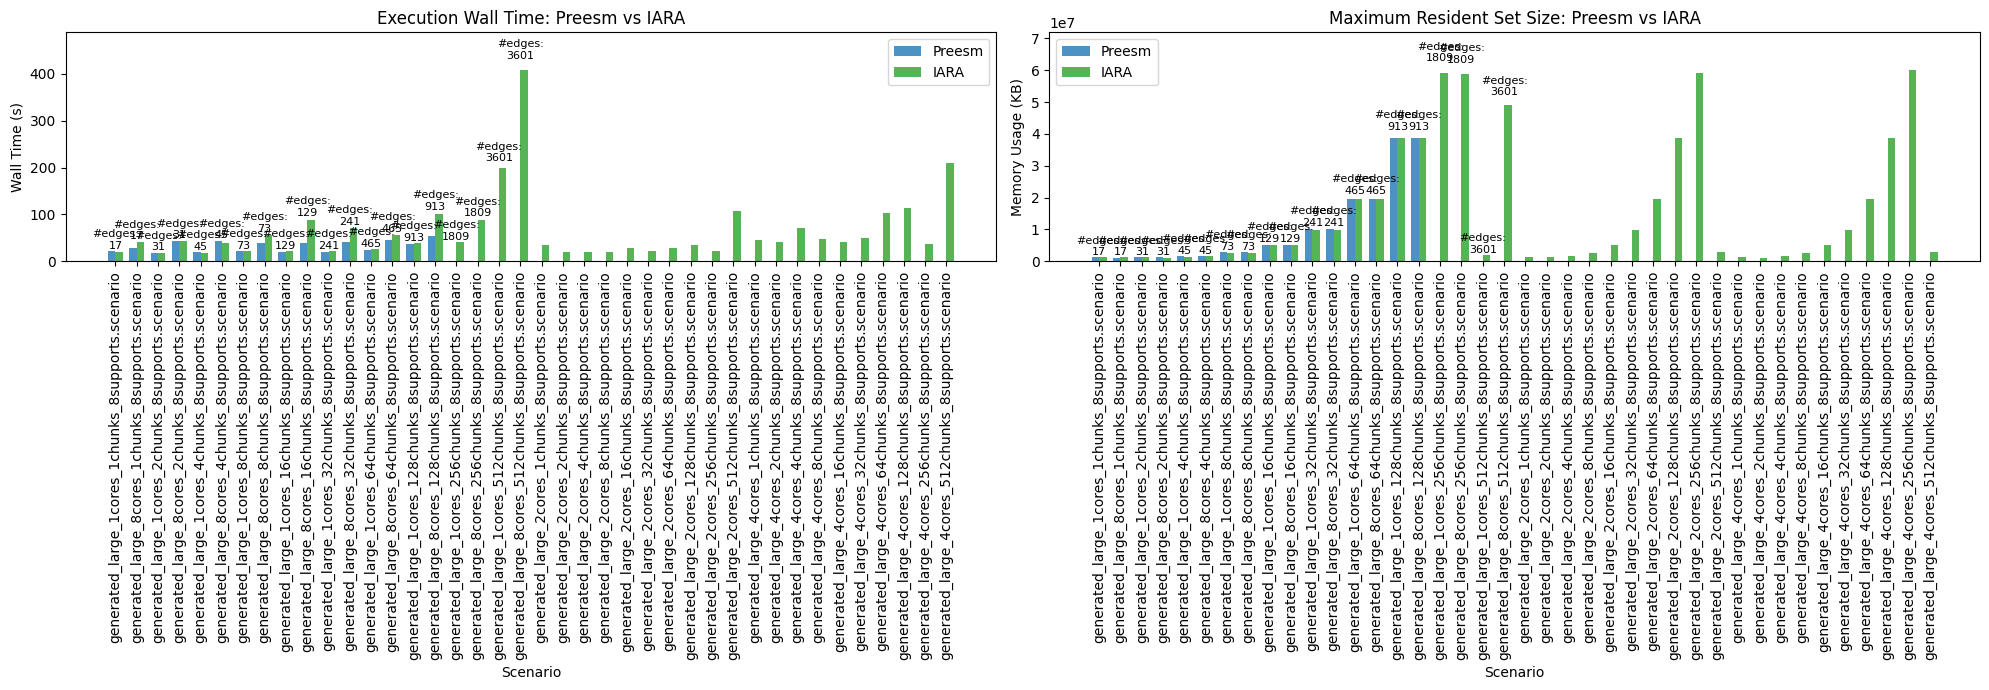

In [31]:
# Combined Performance Comparison (side-by-side bars)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Wall Time Comparison (side-by-side bars)
preesm_wall_colors = ['tab:blue' if t is not None else 'tab:red' for t in preesm_wall_times]
iara_wall_colors = ['tab:green' if t is not None else 'tab:red' for t in iara_wall_times]

bars1 = ax1.bar(x - width/2, [t if t is not None else 0 for t in preesm_wall_times], 
              width, label='Preesm', color=preesm_wall_colors, alpha=0.8)
bars2 = ax1.bar(x + width/2, [t if t is not None else 0 for t in iara_wall_times], 
              width, label='IARA', color=iara_wall_colors, alpha=0.8)

# Add small height for missing data bars to make them visible
missing_height_combined_wall = 0.5
for idx, (preesm_wall_time, iara_wall_time) in enumerate(zip(preesm_wall_times, iara_wall_times)):
    if preesm_wall_time is None:
        bars1[idx].set_height(missing_height_combined_wall)
        bars1[idx].set_alpha(0.5)
    if iara_wall_time is None:
        bars2[idx].set_height(missing_height_combined_wall)
        bars2[idx].set_alpha(0.5)

ax1.set_ylabel('Wall Time (s)')
ax1.set_xlabel('Scenario')
ax1.set_title('Execution Wall Time: Preesm vs IARA')
ax1.set_xticks(x)
ax1.set_xticklabels(scenario_names, rotation=90)
ax1.legend()

# Add "Timeout" labels for missing scenarios
for idx, (preesm_wall_time, iara_wall_time) in enumerate(zip(preesm_wall_times, iara_wall_times)):
    if preesm_wall_time is None:
        ax1.text(x[idx] - width/2, missing_height_combined_wall/2, 'Timeout', 
               ha='center', va='center', color='red', fontsize=8, fontweight='bold')
    if iara_wall_time is None:
        ax1.text(x[idx] + width/2, missing_height_combined_wall/2, 'Timeout', 
               ha='center', va='center', color='red', fontsize=8, fontweight='bold')

# Add edge count labels for wall time
for idx, edge_count in enumerate(srdag_edges):
    if edge_count is not None:
        max_height = max(
            (preesm_wall_times[idx] if preesm_wall_times[idx] is not None else missing_height_combined_wall),
            (iara_wall_times[idx] if iara_wall_times[idx] is not None else missing_height_combined_wall)
        )
        if max_height > missing_height_combined_wall:  # Only add edge labels if we have real data
            ax1.text(x[idx], max_height * 1.05, f"#edges:\n{edge_count}", 
                   ha='center', va='bottom', fontsize=8, color='black')

# Memory Usage Comparison (side-by-side bars)
preesm_rss_colors = ['tab:blue' if rss is not None else 'tab:red' for rss in preesm_max_rss]
iara_rss_colors = ['tab:green' if rss is not None else 'tab:red' for rss in iara_max_rss]

bars3 = ax2.bar(x - width/2, [rss if rss is not None else 0 for rss in preesm_max_rss], 
              width, label='Preesm', color=preesm_rss_colors, alpha=0.8)
bars4 = ax2.bar(x + width/2, [rss if rss is not None else 0 for rss in iara_max_rss], 
              width, label='IARA', color=iara_rss_colors, alpha=0.8)

# Add small height for missing data bars to make them visible
missing_height_combined_rss = 1000
for idx, (preesm_rss, iara_rss) in enumerate(zip(preesm_max_rss, iara_max_rss)):
    if preesm_rss is None:
        bars3[idx].set_height(missing_height_combined_rss)
        bars3[idx].set_alpha(0.5)
    if iara_rss is None:
        bars4[idx].set_height(missing_height_combined_rss)
        bars4[idx].set_alpha(0.5)

ax2.set_ylabel('Memory Usage (KB)')
ax2.set_xlabel('Scenario')
ax2.set_title('Maximum Resident Set Size: Preesm vs IARA')
ax2.set_xticks(x)
ax2.set_xticklabels(scenario_names, rotation=90)
ax2.legend()

# Add "Timeout" labels for missing scenarios
for idx, (preesm_rss, iara_rss) in enumerate(zip(preesm_max_rss, iara_max_rss)):
    if preesm_rss is None:
        ax2.text(x[idx] - width/2, missing_height_combined_rss/2, 'Timeout', 
               ha='center', va='center', color='red', fontsize=8, fontweight='bold')
    if iara_rss is None:
        ax2.text(x[idx] + width/2, missing_height_combined_rss/2, 'Timeout', 
               ha='center', va='center', color='red', fontsize=8, fontweight='bold')

# Add edge count labels for memory usage
for idx, edge_count in enumerate(srdag_edges):
    if edge_count is not None:
        max_height = max(
            (preesm_max_rss[idx] if preesm_max_rss[idx] is not None else missing_height_combined_rss),
            (iara_max_rss[idx] if iara_max_rss[idx] is not None else missing_height_combined_rss)
        )
        if max_height > missing_height_combined_rss:  # Only add edge labels if we have real data
            ax2.text(x[idx], max_height * 1.05, f"#edges:\n{edge_count}", 
                   ha='center', va='bottom', fontsize=8, color='black')

# Set y-axis limits
wall_time_real_data = [t for t in preesm_wall_times + iara_wall_times if t is not None]
if wall_time_real_data:
    wall_time_max = max(wall_time_real_data)
    ax1.set_ylim(0, wall_time_max * 1.2)
else:
    ax1.set_ylim(0, missing_height_combined_wall * 2)

rss_real_data = [rss for rss in preesm_max_rss + iara_max_rss if rss is not None]
if rss_real_data:
    rss_max = max(rss_real_data)
    ax2.set_ylim(0, rss_max * 1.2)
else:
    ax2.set_ylim(0, missing_height_combined_rss * 2)

plt.tight_layout()
plt.show()

In [34]:
# Performance Summary Statistics
print("=== EXPERIMENT SUMMARY ===")
print(f"Total scenarios analyzed: {len(scenario_list)}")
print()

# Compilation success rates
preesm_success = sum(1 for s in preesm_sizes if s is not None)
iara_success = sum(1 for s in iara_sizes if s is not None)
print(f"Compilation Success Rates:")
print(f"  Preesm: {preesm_success}/{len(scenario_list)} ({preesm_success/len(scenario_list)*100:.1f}%)")
print(f"  IARA:   {iara_success}/{len(scenario_list)} ({iara_success/len(scenario_list)*100:.1f}%)")
print()

# Execution success rates
preesm_exec_success = sum(1 for s in preesm_wall_times if s is not None)
iara_exec_success = sum(1 for s in iara_wall_times if s is not None)
print(f"Execution Success Rates:")
print(f"  Preesm: {preesm_exec_success}/{len(scenario_list)} ({preesm_exec_success/len(scenario_list)*100:.1f}%)")
print(f"  IARA:   {iara_exec_success}/{len(scenario_list)} ({iara_exec_success/len(scenario_list)*100:.1f}%)")
print()

# Performance comparison (for successful runs only)
if preesm_exec_success > 0 and iara_exec_success > 0:
    preesm_avg_wall = np.mean([t for t in preesm_wall_times if t is not None])
    iara_avg_wall = np.mean([t for t in iara_wall_times if t is not None])
    preesm_avg_rss = np.mean([r for r in preesm_max_rss if r is not None])
    iara_avg_rss = np.mean([r for r in iara_max_rss if r is not None])
    
    print(f"Average Performance (successful runs only):")
    print(f"  Wall Time - Preesm: {preesm_avg_wall:.2f}s, IARA: {iara_avg_wall:.2f}s")
    print(f"  Max RSS   - Preesm: {preesm_avg_rss:.0f}KB, IARA: {iara_avg_rss:.0f}KB")
    
    if iara_avg_wall > 0:
        speedup = preesm_avg_wall / iara_avg_wall
        print(f"  IARA speedup: {speedup:.2f}x")
    
    if iara_avg_rss > 0:
        memory_ratio = preesm_avg_rss / iara_avg_rss
        print(f"  IARA memory efficiency: {memory_ratio:.2f}x")

print("\nAnalysis complete! All graphs have been generated.")

=== EXPERIMENT SUMMARY ===
Total scenarios analyzed: 40

Compilation Success Rates:
  Preesm: 18/40 (45.0%)
  IARA:   40/40 (100.0%)

Execution Success Rates:
  Preesm: 40/40 (100.0%)
  IARA:   40/40 (100.0%)

Average Performance (successful runs only):
  Wall Time - Preesm: 12.80s, IARA: 62.58s
  Max RSS   - Preesm: 4020353KB, IARA: 15295731KB
  IARA speedup: 0.20x
  IARA memory efficiency: 0.26x

Analysis complete! All graphs have been generated.


1
-0.5
39.5
1
-0.5
39.5
1
-0.5
39.5
1
-0.5
39.5
data_area_start_n: 0.04201969315319442
data_area_end_n: 0.9579803068468056
bar_width_n: 0.07636821616670483


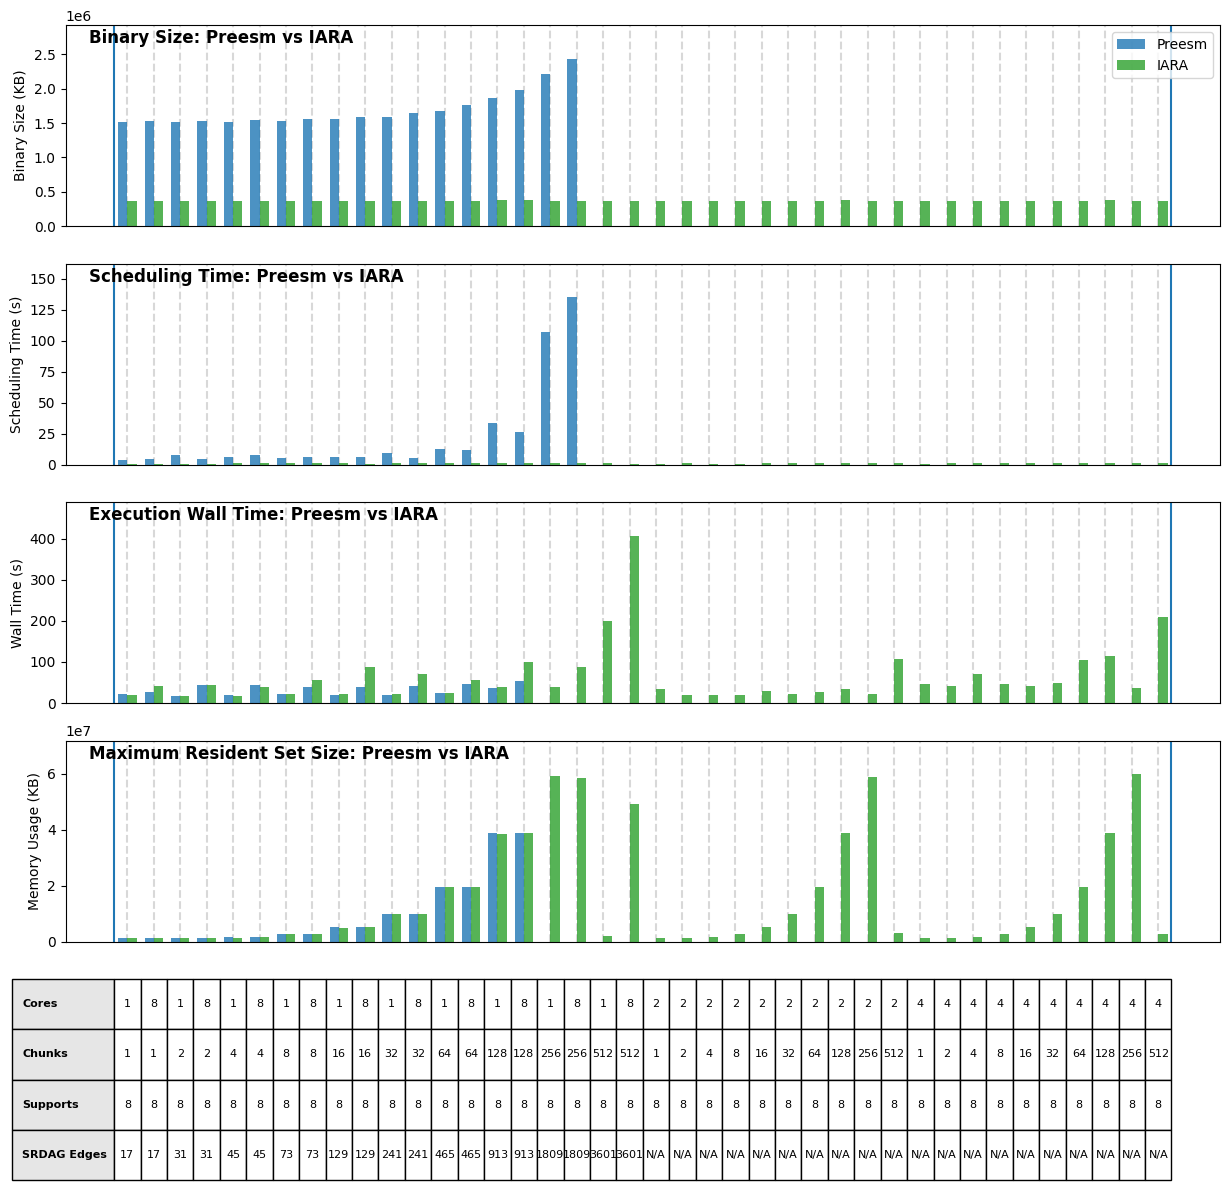

In [233]:
# Combined Vertical Layout - All Performance Metrics
from typing import List, Optional, Any
import matplotlib.pyplot as plt
import matplotlib.axes
import matplotlib.container
import matplotlib.figure
import numpy as np

fig: matplotlib.figure.Figure = plt.figure(figsize=(16, 12))
ax1: matplotlib.axes.Axes = plt.subplot(5, 1, 1)
ax2: matplotlib.axes.Axes = plt.subplot(5, 1, 2)
ax3: matplotlib.axes.Axes = plt.subplot(5, 1, 3)
ax4: matplotlib.axes.Axes = plt.subplot(5, 1, 4)



def create_subplot_bars(ax: matplotlib.axes.Axes, 
                       preesm_data: List[Optional[float]], 
                       iara_data: List[Optional[float]], 
                       missing_height: float, 
                       ylabel: str, 
                       title: str, 
                       show_xlabel: bool = False,
                       show_legend: bool = True) -> None:

    """Helper function to create bars for a subplot with consistent styling"""
    # Create color maps
    preesm_colors: List[str] = [
        'tab:blue' if val is not None else 'tab:red' for val in preesm_data]
    iara_colors: List[str] = [
        'tab:green' if val is not None else 'tab:red' for val in iara_data]

    # Create bars
    bars_preesm: matplotlib.container.BarContainer = ax.bar(
        x - width/2, [val if val is not None else 0 for val in preesm_data],
        width, label='Preesm', color=preesm_colors, alpha=0.8)
    bars_iara: matplotlib.container.BarContainer = ax.bar(
        x + width/2, [val if val is not None else 0 for val in iara_data],
        width, label='IARA', color=iara_colors, alpha=0.8)

# Initialize global variables for table positioning
    global data_area_start
    global data_area_start_n
    global data_area_end_n
    global bar_width_n

    full_width: float = ax.get_xlim()[1]
    bar_width: float = x[1] - x[0]
    data_area_start = x[0] - bar_width / 2
    data_area_end: float = x[-1] + bar_width / 2
    print(bar_width)
    print(data_area_start)
    print(data_area_end)
    graph_l = 0
    graph_r = full_width


    # Get x-axis range for normalization
    x_min, x_max = ax.get_xlim()
    
    def normalize(x_val: float) -> float: 
        return (x_val - x_min) / (x_max - x_min)

    ax.axvline(data_area_end, 0, 1)
    ax.axvline(data_area_start, 0 , 1)

    graph_l_n = normalize(graph_l)
    bar_width_n = normalize(bar_width)
    graph_r_n = normalize(graph_r)
    data_area_start_n = normalize(data_area_start)
    data_area_end_n = normalize(data_area_end)

    # Set labels and legend
    ax.set_ylabel(ylabel)
    if show_legend:
        ax.legend()

    # Add title inside the plot at top left corner
    ax.text(0.02, 0.98, title, transform=ax.transAxes, fontsize=12, fontweight='bold',
            verticalalignment='top', horizontalalignment='left')

    # Handle x-axis labels and tick marks
    if show_xlabel:
        ax.set_xlabel('Scenario')
        ax.set_xticks([])  # Remove x-axis tick marks
        ax.set_xticklabels([])  # Hide x-axis labels - replaced by table below
    else:
        ax.set_xticks([])  # Remove x-axis tick marks
        ax.set_xticklabels([])  # Hide x-axis labels

    # Set y-axis limits
    real_data: List[float] = [val for val in preesm_data + iara_data if val is not None]
    if real_data:
        y_max: float = max(real_data)
        ax.set_ylim(0, y_max * 1.2)
    else:
        ax.set_ylim(0, missing_height * 2)

    # Adjust plot area to match table data area width
    # Leave space for row labels on the left (same as table)
    pos = ax.get_position()

    # Calculate new position: start after row label area, use data_area_width
    new_left: float = graph_l_n
    new_width: float = graph_r_n - graph_l_n

    ax.set_position([0, pos.y0, 1, pos.height])

# Define data configurations for each subplot
subplot_configs: List[dict[str, Any]] = [
    {
        'ax': ax1,
        'preesm_data': preesm_sizes,
        'iara_data': iara_sizes,
        'missing_height': 5000,
        'ylabel': 'Binary Size (KB)',
        'title': 'Binary Size: Preesm vs IARA',
        'show_xlabel': False,
        'show_legend': True
    },
    {
        'ax': ax2,
        'preesm_data': preesm_times,
        'iara_data': iara_times,
        'missing_height': 0.1,
        'ylabel': 'Scheduling Time (s)',
        'title': 'Scheduling Time: Preesm vs IARA',
        'show_xlabel': False,
        'show_legend': False
    },
    {
        'ax': ax3,
        'preesm_data': preesm_wall_times,
        'iara_data': iara_wall_times,
        'missing_height': 0.5,
        'ylabel': 'Wall Time (s)',
        'title': 'Execution Wall Time: Preesm vs IARA',
        'show_xlabel': False,
        'show_legend': False
    },
    {
        'ax': ax4,
        'preesm_data': preesm_max_rss,
        'iara_data': iara_max_rss,
        'missing_height': 1000,
        'ylabel': 'Memory Usage (KB)',
        'title': 'Maximum Resident Set Size: Preesm vs IARA',
        'show_xlabel': False,
        'show_legend': False
    }
]

# Create all subplots using the helper function
for config in subplot_configs:
    create_subplot_bars(**config)

# Add vertical guide lines spanning all subplots
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    for x_pos in x:
        ax.axvline(x=x_pos, color='gray', linestyle='--', alpha=0.3, zorder=0)

# Add parameter table below the plots
table_data: List[List[str]] = []
row_labels: List[str] = ['Cores', 'Chunks', 'Supports', 'SRDAG Edges']

# Transpose data: each row is a parameter, each column is a scenario
cores_row: List[str] = [str(scenario.num_cores) for scenario in scenario_list]
chunks_row: List[str] = [str(scenario.num_chunks) for scenario in scenario_list]
supports_row: List[str] = [str(scenario.num_supports) for scenario in scenario_list]
edges_row: List[str] = [str(scenario.srdag_edges)
             if scenario.srdag_edges is not None else 'N/A' for scenario in scenario_list]

table_data = [cores_row, chunks_row, supports_row, edges_row]

# Create table
table_ax: matplotlib.axes.Axes = fig.add_subplot(5, 1, 5)
table_ax.axis('tight')
table_ax.axis('off')

# Reposition table axis to span full width, matching plots
pos = table_ax.get_position()
table_ax.set_position([0, pos.y0, 1, pos.height])

print(f"data_area_start_n: {data_area_start_n}")
print(f"data_area_end_n: {data_area_end_n}")
print(f"bar_width_n: {bar_width_n}")

# Calculate table positioning using your already computed values
# You want the right edge of the label column to align with data_area_start_n
# The right edge of the table should align with data_area_end_n
num_data_columns = len(scenario_list)
data_area_width_n = data_area_end_n - data_area_start_n

# Choose a reasonable width for the label column
label_column_width_n = 0.15  # Width in normalized coordinates

# Position table so label column right edge aligns with data_area_start_n
# and the table right edge aligns with data_area_end_n
table_left = data_area_start_n # - label_column_width_n
table_width =  data_area_width_n # label_column_width_n +

# Create the table with row and column labels
table = table_ax.table(cellText=table_data,
                       rowLabels=row_labels,
                       cellLoc='center',
                       bbox=[table_left, 0, table_width, 1])

# Set column widths to align properly
# Label column width as fraction of total table width
actual_label_width = label_column_width_n / table_width
# Each data column width as fraction of total table width  
actual_data_width = data_area_width_n / table_width / num_data_columns

# Set the width of the label column (column -1)
for i in range(len(row_labels)):
    table[(i, -1)].set_width(actual_label_width)

# Set the width of data columns to match bar widths
for i in range(len(row_labels)):
    for j in range(num_data_columns):
        table[(i, j)].set_width(actual_data_width)



table.auto_set_font_size(False)
table.set_fontsize(8)

# Style row labels
for i in range(len(row_labels)):
    table[(i, -1)].set_facecolor('#E6E6E6')
    table[(i, -1)].set_text_props(weight='bold')
plt.tight_layout(h_pad=1.0)
plt.show()
